# Swim, Bike, or Run – Which Matters Most for Ironman Success?

This notebook accompanies the Medium article **"Swim, Bike, or Run – Which Matters Most for Ironman Success?"**.

The goal is to quantify how strongly swim, bike, and run performance are linked to overall performance in long-course triathlon (70.3 and full-distance), using:

- Relative performance percentiles per race and gender (`swim_rel`, `bike_rel`, `run_rel`, `overall_rel`)
- Simple correlations
- A basic linear regression model with standardised coefficients ("beta weights")


## Table of Contents

1. [Introduction & Goals](#introduction)
2. [Setup & Configuration](#setup)
3. [Data Loading & Basic Cleaning](#data-loading)
4. [Feature Engineering: Relative Splits](#features)
5. [Correlations: How Each Leg Relates to Overall Performance](#correlations)
6. [Regression: Predicting Overall Performance from Splits](#regression)
7. [Distance & Gender Nuances](#distance-gender)
8. [Summary & Next Steps](#summary)


## 1. Introduction & Goals <a id="introduction"></a>



## 2. Setup & Configuration <a id="setup"></a>

In this section we:

- basically copy paste everything from 01_archetypes.ipynb except for a few imports

In [1]:
# 2. Setup & Configuration

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# just based on my structure and may be adjusted if needed
HOME = Path.home()
DATA_DIR = HOME / "coachcox_results_csv"
OUTPUT_DIR = HOME / "triathlon_outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"DATA_DIR   : {DATA_DIR}")
print(f"OUTPUT_DIR : {OUTPUT_DIR}")

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

warnings.filterwarnings("ignore", category=FutureWarning)


DATA_DIR   : C:\Users\JanBusse\coachcox_results_csv
OUTPUT_DIR : C:\Users\JanBusse\triathlon_outputs


In [2]:
### now create function to read in files

def load_results(path: Path) -> pd.DataFrame: ### function returns data frame
    df = pd.read_csv(path)

    ### get only stem

    base = path.stem

    ### split data accordingly since they have always names like ironman70.3aix-en-provence2011__1181
    # the last 4 digits represent the file number from my scraping job(we can safely cut that)
    # the last 4 digits before the underscore represent the year
    # otherwise, I would keep it simple as is because the race name and location are not always clear

    race_year = base.split("__")[0]

    ### last 4 characters are always race year

    year = int(race_year[-4:])
    race = race_year[:-4]

    df["race"] = race
    df["year"] = year

    # create unique id (file name)
    df["event_id"] = base
    # now extract if race was 70.3 or full distance
    stem_lower = base.lower()
    if "70.3" in stem_lower or "70_3" in stem_lower:
        df["distance"] = "70.3"
    else:
        df["distance"] = "full-distance"
    return df


In [3]:
### now calculate percentile per race


def add_relative_strength(df):
    df = df.copy()
    group_cols = ["race", "year", "gender", "event_id"] ## actually, gender and event_id should be enough

    ### overall percetile
    df["overall_rel"] = (
        df.groupby(group_cols)["Overall Time (s)"]
        .rank(method="average", pct = True, ascending = True)
    )

    ### lowest time is best

    df["overall_rel"] = 1 - df["overall_rel"]

    for col, new_col in [
        ("Swim Time (s)", "swim_rel"),
        ("Bike Time (s)", "bike_rel"),
        ("Run Time (s)", "run_rel"),
    ]:
        perc = (
            df.groupby(group_cols)[col]
            .rank(method="average", pct = True, ascending = True)
        )
        df[new_col] = 1 - perc
    
    return df

## 3. Data Loading & Basic Cleaning <a id="data-loading"></a>

Again, we pretty much copy-paste

In [4]:
files = list(DATA_DIR.glob("*.csv"))
dfs = []
for p in files:
    df_single = load_results(p)
    dfs.append(df_single) ### populate list with data frames
results = pd.concat(dfs, ignore_index=True)

results.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,Age Group Transition 2 Rank,Finish,Qualifier Time,Qualifier Rank,Gender Qualifier Rank,Qualified,race,year,event_id,distance
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,2.0,FIN,08:14:43,1.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,3.0,FIN,08:34:41,2.0,1.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,9.0,FIN,08:35:49,3.0,2.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,23.0,FIN,08:36:10,4.0,3.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,1.0,FIN,08:36:59,5.0,4.0,1.0,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance


In [5]:
### now filter only for athletes who actually finished the race

finisher = results[results["Finish"] == "FIN"].copy()


### all columns containing time related data in string format
time_cols = [
    "Overall Time",
    "Swim Time",
    "Bike Time",
    "Run Time",
    "Transition 1 Time",
    "Transition 2 Time"
]


for col in time_cols:
    sec_col = col + " (s)"
    finisher[sec_col] = pd.to_timedelta(
        finisher[col],
        errors="coerce"
    ).dt.total_seconds()

    # treat 0 as missing (these are “no time recorded”, not real splits)
    finisher.loc[finisher[sec_col] == 0, sec_col] = np.nan

finisher[time_cols + [col + " (s)" for col in time_cols]].head()
finisher.head()

,Bib,Name,Country,gender,Division,Overall Time,Overall Rank,Gender Rank,Age Group Rank,Swim Time,...,race,year,event_id,distance,Overall Time (s),Swim Time (s),Bike Time (s),Run Time (s),Transition 1 Time (s),Transition 2 Time (s)
0,298,Vibeke Hansen,Denmark,Female,F55-59,10:36:04,346.0,11.0,1.0,01:08:55,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,38164.0,4135.0,21124.0,12309.0,356.0,242.0
1,647,Torsten Endres,Germany,Male,M45-49,09:07:29,23.0,22.0,1.0,01:01:46,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32849.0,3706.0,17331.0,11490.0,217.0,108.0
2,579,Niels-Otto Silkj,Denmark,Male,M40-44,08:52:43,14.0,14.0,1.0,00:55:53,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31963.0,3353.0,17186.0,11165.0,154.0,107.0
3,636,Thomas Mortensen,Denmark,Male,M35-39,08:41:39,12.0,12.0,1.0,00:49:17,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,31299.0,2957.0,17159.0,10941.0,136.0,108.0
4,641,Thorstein Gystad,Denmark,Male,M40-44,08:53:55,16.0,16.0,2.0,00:57:22,...,challengecopenhagen,2010,challengecopenhagen2010__210,full-distance,32035.0,3442.0,17514.0,10836.0,163.0,81.0


In [6]:
import numpy as np

# 1) Count how many athletes per event have all three splits
valid_per_event = (
    finisher
    .groupby("event_id")[["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]]
    .apply(lambda g: g.notna().all(axis=1).sum())
    .rename("n_valid_sbr")
    .reset_index()
)

# 2) Choose a threshold
MIN_VALID_SBR = 100  # or 20, 50 – up to you

good_events = valid_per_event.loc[
    valid_per_event["n_valid_sbr"] >= MIN_VALID_SBR,
    "event_id"
]

# 3) Filter finisher down to "true triathlon" events
finisher = finisher[finisher["event_id"].isin(good_events)].copy()

## 4. Feature Engineering: Relative Splits


In [7]:
finisher_rel = add_relative_strength(finisher)
finisher_rel[["race", "year", "gender", "event_id",
              "swim_rel", "bike_rel", "run_rel", "overall_rel"]].head()


,race,year,gender,event_id,swim_rel,bike_rel,run_rel,overall_rel
0,challengecopenhagen,2010,Female,challengecopenhagen2010__210,0.782313,0.709459,0.952703,0.925676
1,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.871304,0.986159,0.968076,0.981034
2,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.961304,0.989619,0.981450,0.987931
3,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.994783,0.991349,0.987921,0.989655
4,challengecopenhagen,2010,Male,challengecopenhagen2010__210,0.944348,0.979239,0.989646,0.986207


In [ ]:
finisher_rel["complete_sbr"] = finisher_rel[
    ["Swim Time (s)", "Bike Time (s)", "Run Time (s)"]
].notna().all(axis=1)

finisher_rel = finisher_rel[finisher_rel["complete_sbr"]].copy()

## 5. Correlations: How Each Leg Relates to Overall Performance <a id="correlations"></a>


In [8]:
### now we are calculating the pearson correlation coefficients
### the results should be values between -1 and 1
### 1 meaning perfect positive linear relationship
### 0 meaning no linear relationship
### -1 perfect neagtive linear relationship

SPLIT_COLS = ["swim_rel", "bike_rel", "run_rel"]
TARGET_COL = "overall_rel" # this is what we are interested in


# now we define a function to compute the corrolation by group
def compute_correlation_by_group(df, group_cols, split_cols, target_col):
    rows = []

    # this splits the dataframe into chunks we are interested in based on our grouping decision
    # since everything is relative to race it doesnt make sense to mix it now
    for group_vals, g in df.groupby(group_cols):
        ## drop na
        g = g.dropna(subset=split_cols + [target_col])


        n = len(g)
        if n < 1000: ## drop small groups
            continue
        row = {}
        # unpack values now into the row
        if isinstance(group_vals, tuple):
            for name, val in zip(group_cols, group_vals):
                row[name] = val
        else:
            row[group_cols[0]] = group_vals

        row["n"] = n 

        for col in split_cols:
            row[f"corr_{col}"] = g[col].corr(g[target_col])

        rows.append(row)

    return pd.DataFrame(rows)


In [9]:
group_cols = ["distance", "gender"]
corr_summary_gender = compute_correlation_by_group(
    finisher_rel,
    group_cols=group_cols,
    split_cols=SPLIT_COLS,
    target_col=TARGET_COL,
)

corr_summary_gender

,distance,gender,n,corr_swim_rel,corr_bike_rel,corr_run_rel
0,70.3,Female,405280,0.693201,0.920564,0.914801
1,70.3,Male,1289199,0.700597,0.921638,0.920512
2,full-distance,Female,183093,0.654759,0.910826,0.914408
3,full-distance,Male,781891,0.668878,0.912326,0.916338


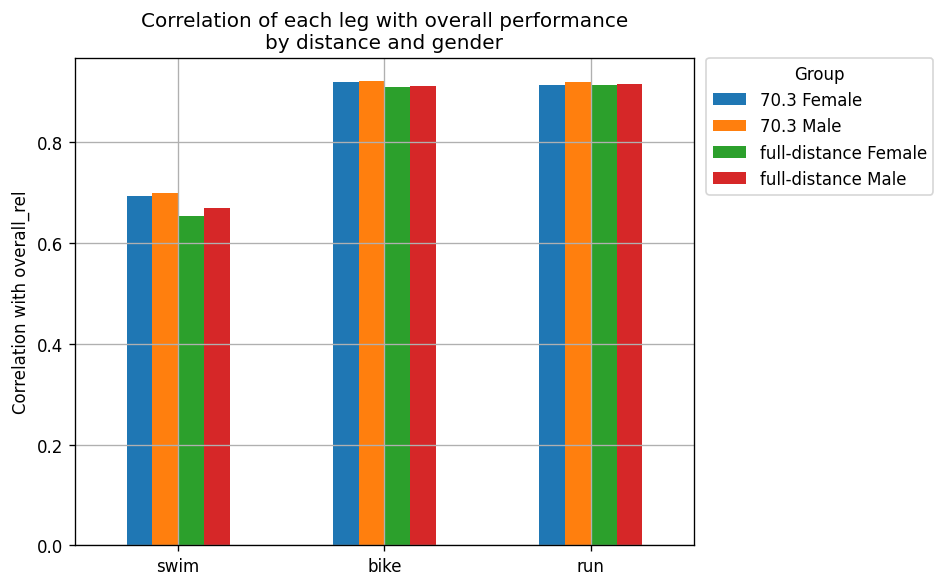

In [10]:
plot_df = corr_summary_gender.copy()
plot_df["group"] = plot_df["distance"] + " " + plot_df["gender"]
plot_df = plot_df.set_index("group")[["corr_swim_rel", "corr_bike_rel", "corr_run_rel"]]
plot_df.columns = ["swim", "bike", "run"]

fig, ax = plt.subplots(figsize=(8, 5))  # a bit wider

plot_df.T.plot(kind="bar", ax=ax)

ax.set_ylabel("Correlation with overall_rel")
ax.set_title("Correlation of each leg with overall performance\nby distance and gender")
plt.xticks(rotation=0)

# move legend outside on the right
ax.legend(
    title="Group",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


In [11]:
### example: distance, gender, year
group_cols = ["distance", "gender", "year"]
corr_summary_year = compute_correlation_by_group(
    finisher_rel,
    group_cols=group_cols,
    split_cols=SPLIT_COLS,
    target_col=TARGET_COL,
)

corr_summary_year

,distance,gender,year,n,corr_swim_rel,corr_bike_rel,corr_run_rel
0,70.3,Female,2005,1115,0.718004,0.931337,0.909356
1,70.3,Female,2006,2069,0.724303,0.922314,0.915592
2,70.3,Female,2007,1776,0.732528,0.930651,0.927384
3,70.3,Female,2008,3171,0.702879,0.898780,0.879674
4,70.3,Female,2009,5817,0.720112,0.923249,0.922144
...,...,...,...,...,...,...,...
84,full-distance,Male,2021,30439,0.660265,0.911891,0.919273
85,full-distance,Male,2022,47691,0.664526,0.910751,0.916897
86,full-distance,Male,2023,38158,0.667123,0.916947,0.921263
87,full-distance,Male,2024,41257,0.684536,0.919693,0.921520


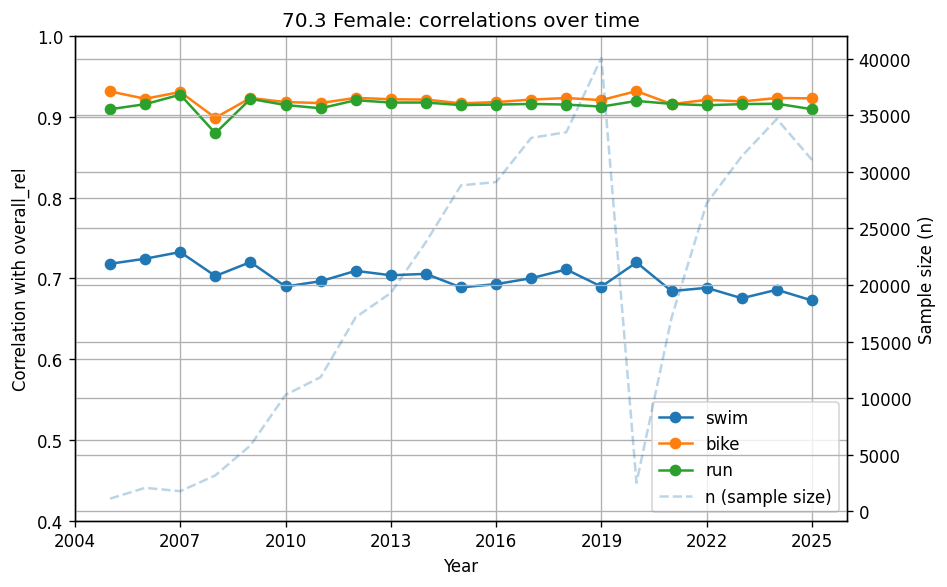

In [12]:
from matplotlib.ticker import MaxNLocator


g = corr_summary_year[
    (corr_summary_year["distance"] == "70.3") &
    (corr_summary_year["gender"] == "Female")
].sort_values("year")

fig, ax1 = plt.subplots()

# 1) Plot all three correlations on the left y-axis
from matplotlib.ticker import MaxNLocator

ax1.plot(g["year"], g["corr_swim_rel"], marker="o", label="swim")
ax1.plot(g["year"], g["corr_bike_rel"], marker="o", label="bike")
ax1.plot(g["year"], g["corr_run_rel"], marker="o", label="run")

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))


ax1.set_xlabel("Year")
ax1.set_ylabel("Correlation with overall_rel")
ax1.set_title("70.3 Female: correlations over time")
ax1.set_ylim(0.4, 1.0)  # optional, just to keep it nicely scaled

# 2) Plot sample size on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(g["year"], g["n"], linestyle="--", alpha=0.3, label="n (sample size)")
ax2.set_ylabel("Sample size (n)")

# 3) Highlight low-n years (e.g. n < 100)
low_n = g[g["n"] < 100]
ax2.scatter(low_n["year"], low_n["n"], s=60, edgecolor="red", facecolor="none")

# Optionally annotate n for low-n points
for _, r in low_n.iterrows():
    ax2.text(r["year"], r["n"], f"n={r['n']}", fontsize=8, ha="center", va="bottom")

# 4) Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")

plt.tight_layout()
plt.show()


## 6. Regression: Predicting Overall Performance from Splits <a id="regression"></a>


In [13]:
### nwo we want to do a simple linear regression


def regression_importance_by_group(df, group_cols, split_cols, target_col, min_n=1000):

    rows = []


    for group_vals, g in df.groupby(group_cols):

        g = g.dropna(subset=split_cols + [target_col])
        n = len(g)
        if n < min_n:
            continue
        
        ### now extraxt X and Y

        X = g[split_cols].values ## 2d array with swim, bike, and run times
        y = g[target_col].values.reshape(-1, 1) # target vector

        ### standardise X and y so that coefficients are beta weights & comparable
        ### the scaler only substracts the mean and divides by standard deviation -> thus standardisation
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_std = scaler_X.fit_transform(X)
        y_std = scaler_y.fit_transform(y).ravel() # ravel is a standard function to flatten the shape as expected for linear regression

        model = LinearRegression()
        model.fit(X_std, y_std)

        row = {}


        ### same as before
        if isinstance(group_vals, tuple):
            for name, val in zip(group_cols, group_vals):
                row[name] = val
        else:
            row[group_cols[0]] = group_vals
        
        row["n"] = n # n iis simple the sample size
        row["r2"] = model.score(X_std, y_std) # r2 is the proportion of variance actually explained by the model

        for col, coef in zip(split_cols, model.coef_):
            row[f"beta_{col}"] = coef
        
        rows.append(row)
    return pd.DataFrame(rows)



In [14]:
group_cols = ["distance", "gender"]

reg_summary = regression_importance_by_group(
    finisher_rel,
    group_cols=group_cols,
    split_cols=SPLIT_COLS,
    target_col=TARGET_COL,
    min_n=100,  # adjust if needed
)

reg_summary


,distance,gender,n,r2,beta_swim_rel,beta_bike_rel,beta_run_rel
0,70.3,Female,405280,0.985618,0.141782,0.474512,0.492475
1,70.3,Male,1289199,0.986413,0.138433,0.460633,0.505035
2,full-distance,Female,183093,0.986323,0.126599,0.460529,0.529271
3,full-distance,Male,781891,0.987454,0.121702,0.456992,0.533782


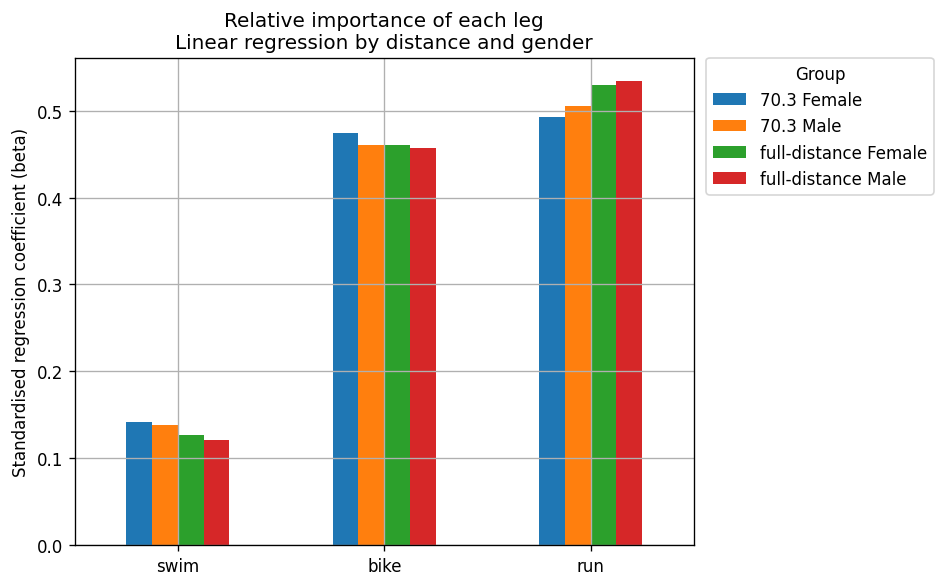

In [15]:
plot_reg = reg_summary.copy()
plot_reg["group"] = plot_reg["distance"] + " " + plot_reg["gender"]

# Keep only the beta columns, index by group
plot_reg = plot_reg.set_index("group")[["beta_swim_rel", "beta_bike_rel", "beta_run_rel"]]
plot_reg.columns = ["swim", "bike", "run"]

fig, ax = plt.subplots(figsize=(8, 5))

plot_reg.T.plot(kind="bar", ax=ax)

ax.set_ylabel("Standardised regression coefficient (beta)")
ax.set_title("Relative importance of each leg\nLinear regression by distance and gender")
plt.xticks(rotation=0)

ax.legend(
    title="Group",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


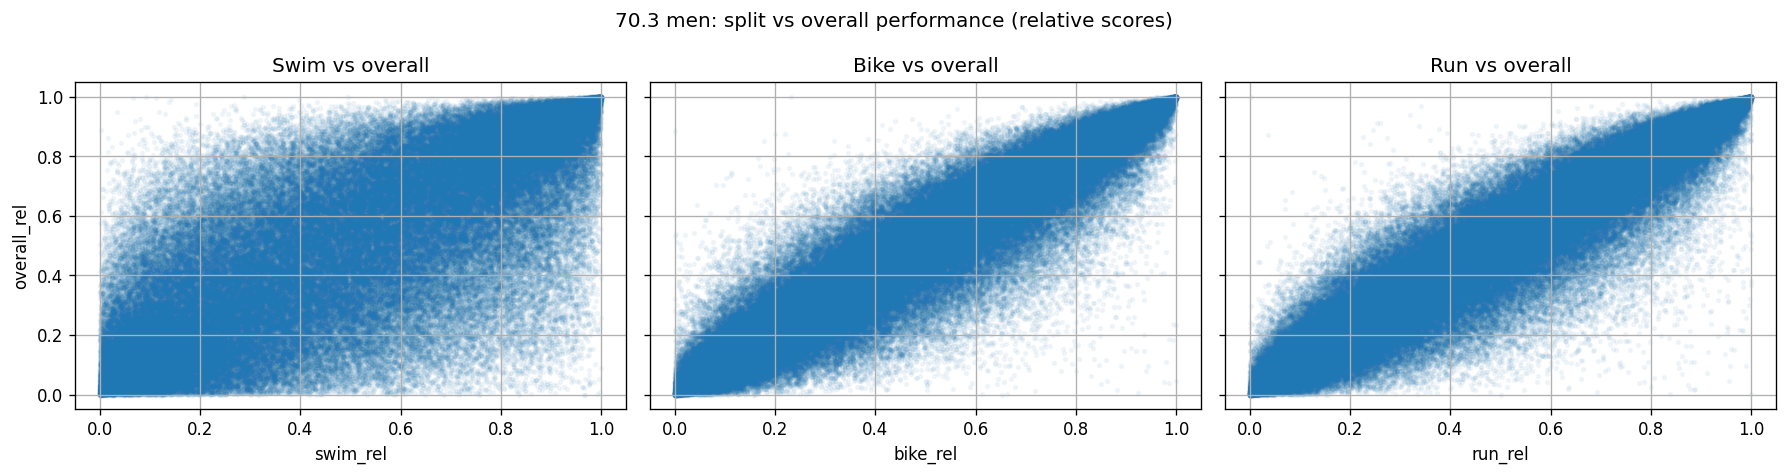

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# choose one group, e.g. 70.3 men
mask = (finisher_rel["distance"] == "70.3") & (finisher_rel["gender"] == "Male")
g = finisher_rel.loc[mask].dropna(subset=["swim_rel", "bike_rel", "run_rel", "overall_rel"])

# sample for plotting
g_sample = g.sample(150000, random_state=42)  # adjust n if needed

legs = ["swim_rel", "bike_rel", "run_rel"]
titles = ["Swim vs overall", "Bike vs overall", "Run vs overall"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, leg, title in zip(axes, legs, titles):
    ax.scatter(
        g_sample[leg],
        g_sample["overall_rel"],
        s=5,
        alpha=0.05,
    )
    ax.set_xlabel(leg)
    ax.set_title(title)

axes[0].set_ylabel("overall_rel")
fig.suptitle("70.3 men: split vs overall performance (relative scores)")
plt.tight_layout()
plt.show()
